In [1]:
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from datasets import load_dataset
import matplotlib.pyplot as plt
from operator import itemgetter
from torch.utils.data import default_collate, DataLoader

In [2]:
name = 'fashion_mnist'
x,y = 'image','label'
dsd = load_dataset(name)

Found cached dataset fashion_mnist (/Users/arun/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [4]:
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

@inplace
def transformi_(b):
    b[x] = [torch.flatten(TF.to_tensor(ele)) for ele in b[x]]

In [5]:
def get_dls(train_ds, valid_ds, batch_size, **kwargs):
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs),
        DataLoader(valid_ds, batch_size=batch_size*2, shuffle=False, **kwargs),
    )

def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b):
        return get(default_collate(b))
    return _f

class DataLoaders:
    def __init__(self, *ds):
        self.train,self.valid = ds[:2]
    
    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), batch_size=batch_size, collate_fn=f, **kwargs))  

In [6]:
tds = dsd.with_transform(transformi_)

In [7]:
bs = 1024
dls = DataLoaders.from_dd(tds, batch_size=bs)

In [8]:
t = iter(dls.train)

In [9]:
xb, yb = next(t)

'Sneaker'

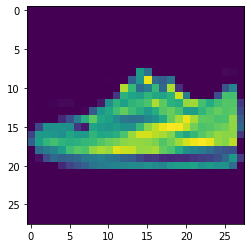

In [10]:
i = 11
plt.imshow(xb[i].view(28, 28))
dsd['train'].features['label'].int2str(yb[i].item())

In [11]:
import fastcore.all as fc
import torch.optim as optim
import torch.nn as nn

In [12]:
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
def_device

'cpu'

In [14]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()
    def calc_stats(self):
        acc = (self.preds.argmax(dim=1) == self.yb).float().sum()
        n = len(self.xb)
        self.accs.append(acc)
        self.losses.append(self.loss*n)
        self.ns.append(n)
    
    def one_batch(self):
        self.xb,self.yb = self.batch
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad():
            self.calc_stats()  
    
    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num, self.batch in enumerate(dl): 
            self.one_batch()
        n = sum(self.ns)
        print(f'training:{self.model.training}, epoch:{self.epoch}, loss:{sum(self.losses).item()/n},\
              accuracy:{sum(self.accs).item()/n}')
    
    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), lr=self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(self.n_epochs):
            self.one_epoch(True)
        with torch.no_grad():
            self.one_epoch(False)

In [15]:
n,nh = 28*28,50
model = nn.Sequential(*[nn.Linear(n, nh), nn.ReLU(nh), nn.Linear(nh, 10)])

In [16]:
learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.2)

In [17]:
learn.fit(2)

training:True, epoch:0, loss:1.1884450520833334,              accuracy:0.5995166666666667
training:True, epoch:1, loss:0.9456514973958333,              accuracy:0.674475
training:False, epoch:1, loss:0.9268530048076923,              accuracy:0.6796


In [18]:
from operator import attrgetter

In [19]:
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None:
            method(learn)

In [20]:
class CancelFitException(Exception):
    pass
class CancelBatchException(Exception):
    pass
class CancelEpochException(Exception):
    pass

In [21]:
class Callback:
    order = 0

In [22]:
class CompletionCB(Callback):
    def before_fit(self, learn):
        self.count = 0
        
    def after_batch(self, learn):
        self.count += 1
    
    def after_fit(self, learn):
        print(f'Completed {self.count} batches')

In [23]:
n,nh = 28*28,50
def get_model():
    return nn.Sequential(*[nn.Linear(n, nh), nn.ReLU(nh), nn.Linear(nh, 10)])

In [78]:
class Metric:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.ns,self.vals = [],[]
    
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    
    def calc(self, inp, targ):
        return inp

    @property
    def value(self):
        ns = torch.tensor(self.ns)
        vals = torch.tensor(self.vals)
        return (vals*ns).sum()/ns.sum()

In [79]:
class Accuracy(Metric):
    def calc(self, inp, targ):
        return (inp== targ).float().mean()

In [80]:
acc = Accuracy()

In [81]:
acc.add(torch.tensor([3, 1, 2, 0, 1, 2]), torch.tensor([0, 1, 1, 2, 1, 0]))
acc.add(torch.tensor([1, 1, 2, 0, 5]), torch.tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.2667)

In [82]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.6176), 0.62)

In [83]:
from torcheval.metrics import MulticlassAccuracy, Mean

In [84]:
metric = MulticlassAccuracy()
metric.update(torch.tensor([3, 1, 2, 0, 1, 2]), torch.tensor([0, 1, 1, 2, 1, 0]))
metric.update(torch.tensor([1, 1, 2, 0, 5]), torch.tensor([0, 1, 1, 2, 1]))
metric.compute()

tensor(0.2727)

In [85]:
from collections.abc import Mapping
from copy import copy

In [86]:
def to_cpu(x):
    if isinstance(x, Mapping): 
        return {k:to_cpu(v) for k, v in x.items()}
    if isinstance(x, list):
        return [to_cpu(ele) for ele in x]
    if isinstance(x, tuple):
        return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype == torch.float16 else res

In [87]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[o.__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
    
    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]
    
    def after_epoch(self, learn):
        log = {k:f'{v.compute()}' for k, v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)
    
    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [88]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs=[], opt_func=optim.SGD): fc.store_attr()
    def calc_stats(self):
        acc = (self.preds.argmax(dim=1) == self.yb).float().sum()
        n = len(self.xb)
        self.accs.append(acc)
        self.losses.append(self.loss*n)
        self.ns.append(n)
    
    def one_batch(self):
        self.xb,self.yb = self.batch
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad():
            self.calc_stats()  
    
    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.num, self.batch in enumerate(dl): 
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException:
                    pass
            self.callback('after_epoch')
        except CancelEpochException:
            pass
       
    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), lr=self.lr)
        self.n_epochs = n_epochs
        try:
            self.callback('before_fit')
            for self.epoch in range(self.n_epochs):
                self.one_epoch(True)
            with torch.no_grad():
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException:
            pass
    
    def callback(self, method_nm):
        run_cbs(self.cbs, method_nm, self)

In [89]:
model = get_model()
metric = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, lr=0.2, loss_func=F.cross_entropy, cbs=[metric])

In [90]:
learn.fit(3)

{'accuracy': '0.6327499747276306', 'loss': '1.171434762064616', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.7446500062942505', 'loss': '0.7085846827189127', 'epoch': 1, 'train': 'train'}
{'accuracy': '0.7824000120162964', 'loss': '0.6112953526814778', 'epoch': 2, 'train': 'train'}
{'accuracy': '0.7728000283241272', 'loss': '0.6063536010742188', 'epoch': 2, 'train': 'eval'}


In [91]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for m in ms:
            metrics[o.__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
    
    def before_fit(self, learn):
        learn.metrics = self
    
    def before_epoch(self, learn):
        [o.reset() for o in self.all_metrics.values()]
    
    def after_batch(self, learn):
        x,y,*_ = learn.batch
        for m in self.metrics.values():
            m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))
    
    def _log(self, d):
        print(d)
    
    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k, v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

In [92]:
model = get_model()

In [93]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())

In [94]:
metrics.all_metrics

{'accuracy': <torcheval.metrics.classification.accuracy.MulticlassAccuracy at 0x1794e9d50>,
 'loss': <torcheval.metrics.aggregation.mean.Mean at 0x177385910>}

In [95]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[metrics])
learn.fit(1)

{'accuracy': '0.606', 'loss': '1.176', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.695', 'loss': '0.793', 'epoch': 0, 'train': 'eval'}


In [96]:
def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

class DeviceCB(Callback):
    def __init(self, device=def_device): fc.store_attr()
    def before_fit(self, learn): 
        if hasattr(learn.model, 'to'):learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

In [97]:
def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor):
        return x.to(device)
    if isinstance(x, Mapping):
        return {k:v.to(device) for k, v in x.items()}
    return type(x)(to_device(o, device) for o in x)

class DeviceCB(Callback):
    def __init__(self, device=def_device):
        fc.store_attr()
    
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'):
            learn.model.to(self.device)
    
    def before_batch(self, learn):
        learn.batch = to_device(learn.batch, device=self.device)

In [98]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'accuracy': '0.746', 'loss': '0.710', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.735', 'loss': '0.707', 'epoch': 0, 'train': 'eval'}


In [99]:
from contextlib import contextmanager
from functools import partial
from fastprogress import progress_bar,master_bar

In [100]:
class Learner:
    def __init__(self, modele, dls=(0,), lr=0.1, loss_func=F.mse_loss, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()
    
    @contextmanager
    def cb_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']:
            pass
        finally:
            self.callback(f'cleanup_{nm}')
    
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.epoch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, model, train=True, valid=True, n_epochs=1, cbs=None, lr=None):
        cbs = fc.L(cbs)
        for cb in cbs:
            self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train:
                        self.one_epoch(True)
                    if valid:
                        with torch.no_grad():
                            self.one_epoch(False)
        finally:
            for cb in cbs:
                self.cbs.remove(cb)
    
    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'):
            return partial(self.callback, name)
        raise AttributeError(name)
        
    def callback(self, method_nm):
        run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self):
        return self.model.training

In [101]:
class TrainCB(Callback):
    def __init__(self, n_inp=1):
        self.n_inp = n_inp
    
    def predict(self, learn):
        learn.preds = learn.model(*learn.batch[:self.n_inp])
    
    def get_loss(self, learn):
        learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    
    def backward(self, learn):
        learn.loss.backward()
    
    def step(self, learn):
        learn.opt.step()
    
    def zero_grad(self, learn):
        learn.opt.zero_grad()

In [102]:
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False):
        self.plot = plot
    
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'):
            learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []
    
    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first =False
        self.mbar.write(list(d.values()), table=True)
    
    def before_epoch(self, learn):
        learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses:
                self.mbar.update_graph()
        

In [137]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @contextmanager
    def cb_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')
                
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training
     

In [145]:
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()
     


In [152]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses:
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],\
                    [fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
   
    def ater_epoch(self, learn):
        if not learn.training:
            self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses],\
                    [fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

In [153]:
model = get_model()

In [154]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())

In [155]:
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [156]:
learn = Learner(model, dls, loss_func=F.cross_entropy, cbs=cbs, lr=0.2, )

In [158]:
learn.fit(2)

accuracy,loss,epoch,train
0.779,0.616,0,train
0.764,0.679,0,eval
0.800,0.567,1,train
0.796,0.564,1,eval


In [161]:
class with_cbs:
    def __init__(self, nm):
        self.nm = nm
    
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cacnel{self.nm.title()}Exception']:
                pass
            finally:
                o.callback(f'cleanup_{self.nm}')
        return _f

In [169]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @contextmanager
    def cb_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')
                
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

In [170]:
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In [171]:
model = get_model()

In [172]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)

accuracy,loss,epoch,train
0.618,1.185,0,train
0.684,0.809,0,eval
0.735,0.721,1,train
0.736,0.711,1,eval
